# Detecting Diabetic Retinopathy to Stop Blindness using Aravind Eye Hospital's Data 

Millions of people suffer from [diabetic retinopathy](https://nei.nih.gov/health/diabetic/retinopathy), the leading cause of blindness among working aged adults. Aravind Eye Hospital in India hopes to detect and prevent this disease among people living in rural areas where medical screening is difficult to conduct. <br>
Currently, Aravind technicians travel to these rural areas to capture images and then rely on highly trained doctors to review the images and provide diagnosis. Their goal is to scale their efforts through technology; to gain the ability to automatically screen images for disease and provide information on how severe the condition may be. <br>
In this project, we will try to build a deep learning model to classify thousands of eye images from Aravind Eye Hospital based on the severity of the diabetic retinopathy. <br>
This project is inspired by [APTOS 2019 Blindness Detection](https://www.kaggle.com/c/aptos2019-blindness-detection/overview) competition on Kaggle. 

---



## Setting up the Training Data
Let's download the dataset from Kaggle, but first we will need to get a API key to be able to access the data: 

In [0]:
#set up kaggle
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
#upload the api key
from google.colab import files
files.upload()

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
AnalyzeBoston/crimes-in-boston                              Crimes in Boston                                     10MB  2018-09-04 17:56:03           9364  
matheusfreitag/gas-prices-in-brazil                         Gas Prices in Brazil                                  3MB  2019-07-12 16:23:52           5153  
jealousleopard/goodreadsbooks                               Goodreads-books                                     632KB  2019-06-14 16:35:05           8848  
wkirgsn/electric-motor-temperature                          Electric Motor Temperature                           47MB  2019-06-19 11:12:41           3346  
jolasa/waves-measuring-buoys-data-mooloolaba                Wave

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

Now after we were able to athenticate:

In [0]:
!kaggle competitions download -c aptos2019-blindness-detection
!ls

100% 8.00G/8.01G [00:50<00:00, 166MB/s]
100% 8.01G/8.01G [00:51<00:00, 169MB/s]
 99% 1.49G/1.50G [00:08<00:00, 205MB/s]
100% 1.50G/1.50G [00:08<00:00, 189MB/s]
  0% 0.00/53.7k [00:00<?, ?B/s]
100% 53.7k/53.7k [00:00<00:00, 37.9MB/s]
  0% 0.00/24.5k [00:00<?, ?B/s]
100% 24.5k/24.5k [00:00<00:00, 21.0MB/s]
  0% 0.00/28.3k [00:00<?, ?B/s]
100% 28.3k/28.3k [00:00<00:00, 29.4MB/s]
kaggle.json  sample_submission.csv  test_images.zip  train_images.zip
sample_data  test.csv		    train.csv


In [0]:
!unzip train_images.zip

Archive:  train_images.zip
  inflating: 7b9d519cbd66.png        
  inflating: ae49cc60f251.png        
  inflating: b294927b14b0.png        
  inflating: f4d3777f2710.png        
  inflating: d74ccc796517.png        
  inflating: 15bed5adde74.png        
  inflating: f002ce614c59.png        
  inflating: 7335a2d43ada.png        
  inflating: 9b7b6e4db1d5.png        
  inflating: 1968183f0e61.png        
  inflating: d91273efb92a.png        
  inflating: 5cf9127f251a.png        
  inflating: 370f575adb23.png        
  inflating: 4c17e85686f0.png        
  inflating: 4f7755e74a9e.png        
  inflating: 25e9fd872182.png        
  inflating: b64e1eef3d63.png        
  inflating: e7d2c2c3b30f.png        
  inflating: bfda2fd0533a.png        
  inflating: 224bb938e2dd.png        
  inflating: d51e5d7484ea.png        
  inflating: dc6fa1b38b83.png        
  inflating: 74898f372d2b.png        
  inflating: 152db3de8120.png        
  inflating: 07929d32b5b3.png        
  inflating: 0773a1c326

## Reading the Train Set
let's start by reading the train set:

In [0]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [0]:
import pandas as pd
import numpy as np
SEED = 42
np.random.seed(SEED)
train=pd.read_csv("/content/train.csv")
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [0]:
len(train)

3662

Based on the data description provided [on Kaggle](https://www.kaggle.com/c/aptos2019-blindness-detection/data), we are provided with a large set of retina images taken using [fundus photography](https://en.wikipedia.org/wiki/Fundus_photography) under a variety of imaging conditions. <br>

A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:<br>

0 - No DR <br><br>

1 - Mild <br><br> 

2 - Moderate <br><br>

3 - Severe<br><br>

4 - Proliferative DR <br><br>

Like any real-world data set, we will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. The images were gathered from multiple clinics using a variety of cameras over an extended period of time, which will introduce further variation. In the upcoming steps we will try to preprocess the images to better highlight some important features.

Let's read the test data into a Pandas dataframe:

In [0]:
test=pd.read_csv("/content/test.csv")

Next, let's create a dictionnary that divides the images ids into 4 classes based on the diagnosis:

In [0]:
dict={0:"No DR",
    1:"Mild",
    2:"Moderate",
    3:"Severe",
    4:"Profilerative DR"}
dict

{0: 'No DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Profilerative DR'}

In [0]:
diags={}
for k in dict.keys():
  diags[k]=train[train["diagnosis"]==k]
diags

{0:            id_code  diagnosis
 3     002c21358ce6          0
 4     005b95c28852          0
 6     0097f532ac9f          0
 10    00cc2b75cddd          0
 12    00f6c1be5a33          0
 15    0125fbd2e791          0
 17    014508ccb9cb          0
 18    0151781fe50b          0
 21    0182152c50de          0
 24    01d9477b1171          0
 26    01f7bb8be950          0
 27    0212dd31f623          0
 28    022f820027b8          0
 29    0231642cf1c2          0
 30    0232dfea7547          0
 31    02358b47ea89          0
 36    02cd34a85b24          0
 37    02da652c74b8          0
 39    0304bedad8fe          0
 48    03b373718013          0
 55    0423237770a7          0
 57    04579e31e4be          0
 60    04aef84a2cc1          0
 62    04efb1a284cc          0
 63    050bb1eafa76          0
 64    05113073b268          0
 65    05195a3db5e2          0
 68    05339950962e          0
 69    054b1b305160          0
 70    0551676cc2aa          0
 ...            ...        ...
 3605

Let's now check the distribution of each class in the train set:

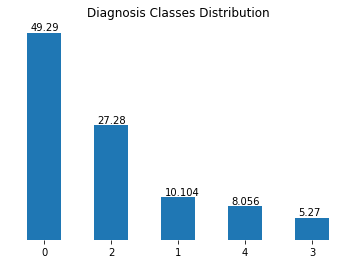

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

cases=train["diagnosis"].value_counts(normalize=True,ascending=False)*100
ax=cases.plot(kind="bar")
ax.set_xticklabels(cases.index,rotation=0)
ax.set_title("Diagnosis Classes Distribution")
for i, v in enumerate(cases.values):
    ax.text(i-0.2, v+0.5, str(round(v,3)))
for sp in ax.spines.keys():
  ax.spines[sp].set_visible(False)
ax.set_yticks([])
plt.show()

We notice that the classes are not uniformly distributed; we notice that around 50% of the train data is classified as part of class 0, and around 27.28% classified as part of class 1. These 2 classes only accouts for more that 75% of the training data, which will inrease the risks that the trained model to be largely affected by this bias in data. <br>
One solution is to calculate a weight for each class that will balance out the skew in the data and even out the distribution, which we will feed later on to the model as a seperate parameter.

In [0]:
weights=1./(train["diagnosis"].value_counts(normalize=True))
weights=weights/weights[0]
weights

0    1.000000
2    1.806807
1    4.878378
4    6.118644
3    9.352332
Name: diagnosis, dtype: float64

## Exploratory Data Analysis
Let's examine some random images of each class:

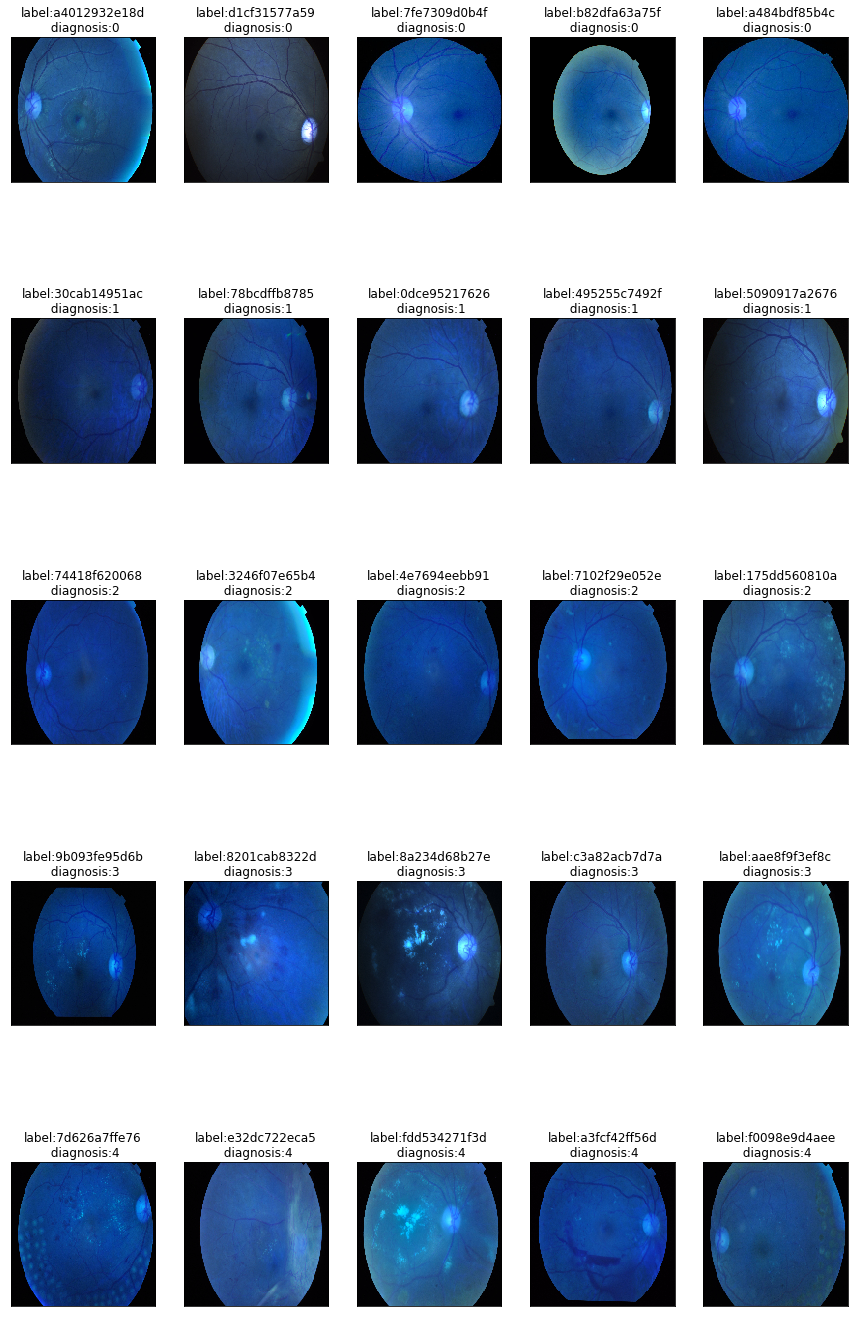

In [0]:
import cv2
from google.colab.patches import cv2_imshow

fig=plt.figure(figsize=(15,25))
for i,k in enumerate(diags.keys()):
  for j,v in enumerate(np.random.choice(diags[k]["id_code"],size=5)):
    ax=fig.add_subplot(5,5,5*(i) +(j+1),xticks=[], yticks=[])
    image=cv2.imread(v+".png",cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(150,150))
    plt.imshow(image)
    ax.set_title("label:"+v+"\n diagnosis:"+str(k))
plt.show()

## Preparing the Training Folders Architecture

First, let's start by creating the train, validation and test folders in the home directory:

In [0]:
!mkdir -p data/test
!mkdir -p data/validation
!mkdir -p data/train
!pwd

/content


In [0]:
#set directories variables
import os, shutil

home_dir = '/content'
base_dir = os.path.join(home_dir, 'data')
base_dir
train_dir=os.path.join(base_dir,"train")
print("train directory: "+train_dir)

test_dir=os.path.join(base_dir,"test")
print("test directory: "+test_dir)

validation_dir=os.path.join(base_dir,"validation")
print("validation directory: "+validation_dir)

train_0_dir = os.path.join(base_dir, 'train', '0')
train_1_dir = os.path.join(base_dir, 'train', '1')
train_2_dir = os.path.join(base_dir, 'train', '2')
train_3_dir = os.path.join(base_dir, 'train', '3')
train_4_dir = os.path.join(base_dir, 'train', '4')

test_0_dir = os.path.join(base_dir, 'test', '0')
test_1_dir = os.path.join(base_dir, 'test', '1')
test_2_dir = os.path.join(base_dir, 'test', '2')
test_3_dir = os.path.join(base_dir, 'test', '3')
test_4_dir = os.path.join(base_dir, 'test', '4')

validation_0_dir = os.path.join(base_dir, 'validation', '0')
validation_1_dir = os.path.join(base_dir, 'validation', '1')
validation_2_dir = os.path.join(base_dir, 'validation', '2')
validation_3_dir = os.path.join(base_dir, 'validation', '3')
validation_4_dir = os.path.join(base_dir, 'validation', '4')

train directory: /content/data/train
test directory: /content/data/test
validation directory: /content/data/validation


In [0]:
#append .png to all files names
for df in diags.values():
  df["id_code_png"]=df["id_code"]+".png"
print(diags.values())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


dict_values([           id_code  diagnosis       id_code_png
3     002c21358ce6          0  002c21358ce6.png
4     005b95c28852          0  005b95c28852.png
6     0097f532ac9f          0  0097f532ac9f.png
10    00cc2b75cddd          0  00cc2b75cddd.png
12    00f6c1be5a33          0  00f6c1be5a33.png
15    0125fbd2e791          0  0125fbd2e791.png
17    014508ccb9cb          0  014508ccb9cb.png
18    0151781fe50b          0  0151781fe50b.png
21    0182152c50de          0  0182152c50de.png
24    01d9477b1171          0  01d9477b1171.png
26    01f7bb8be950          0  01f7bb8be950.png
27    0212dd31f623          0  0212dd31f623.png
28    022f820027b8          0  022f820027b8.png
29    0231642cf1c2          0  0231642cf1c2.png
30    0232dfea7547          0  0232dfea7547.png
31    02358b47ea89          0  02358b47ea89.png
36    02cd34a85b24          0  02cd34a85b24.png
37    02da652c74b8          0  02da652c74b8.png
39    0304bedad8fe          0  0304bedad8fe.png
48    03b373718013         

Next, we will group all entries belonging to the same classes into distinct folders to prepare data for ImageDataGenerator Class training:

In [0]:
from glob import glob
from tqdm import tqdm

for i in dict.keys():
  n_digits = int(np.log10(len(diags[i]))) + 1
  base_name = str(i)+"{}.png"
  for k, fname in tqdm(enumerate(diags[i]["id_code_png"])):
    new_name = base_name.format(str(k).zfill(n_digits))
    os.rename(fname, new_name)
    
    

1805it [00:00, 31795.58it/s]
370it [00:00, 29763.95it/s]
999it [00:00, 29883.46it/s]
193it [00:00, 25315.09it/s]
295it [00:00, 26698.59it/s]


Next, we will split the training data into train set (75%) and validation set (15%):

In [0]:
import numpy as np
from glob import glob
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

filenames=[]
zeros=glob('0???.png')+glob('0????.png')
for k in dict.keys():
  filenames = glob(str(k)+'???.png')+filenames
filenames=zeros+filenames

train_names , val_test_names = train_test_split(filenames, test_size=0.15)

for valname in val_test_names:
    os.rename(valname, 'data/validation/' + valname)

#for testname in test_names:
#    os.rename(testname, 'data/test/' + testname)

for trainname in train_names:
    os.rename(trainname, 'data/train/' + trainname)

In [0]:
!mkdir -p data/train/0/ 
!mv data/train/0*.png data/train/0/ 

!mkdir -p data/train/1/ 
!mv data/train/1*.png data/train/1/ 

!mkdir -p data/train/2/ 
!mv data/train/2*.png data/train/2/ 

!mkdir -p data/train/3/ 
!mv data/train/3*.png data/train/3/ 

!mkdir -p data/train/4/ 
!mv data/train/4*.png data/train/4/ 

In [0]:
ls data/train/2

2001.png  2119.png  2247.png  2375.png  2498.png  2630.png  2752.png  2878.png
2002.png  2120.png  2248.png  2376.png  2499.png  2631.png  2753.png  2879.png
2003.png  2121.png  2249.png  2377.png  2500.png  2632.png  2754.png  2880.png
2004.png  2122.png  2250.png  2378.png  2504.png  2634.png  2755.png  2881.png
2005.png  2123.png  2251.png  2379.png  2505.png  2635.png  2757.png  2882.png
2006.png  2124.png  2252.png  2380.png  2508.png  2636.png  2759.png  2883.png
2007.png  2125.png  2254.png  2381.png  2509.png  2638.png  2760.png  2884.png
2008.png  2126.png  2255.png  2382.png  2510.png  2639.png  2761.png  2885.png
2009.png  2127.png  2256.png  2383.png  2511.png  2641.png  2763.png  2886.png
2010.png  2129.png  2257.png  2384.png  2512.png  2643.png  2767.png  2887.png
2011.png  2130.png  2258.png  2385.png  2513.png  2644.png  2768.png  2888.png
2012.png  2131.png  2259.png  2386.png  2515.png  2646.png  2769.png  2889.png
2014.png  2132.png  2260.png  2388.png  2516.png  26

In [0]:
!mkdir -p data/validation/0/ 
!mv data/validation/0*.png data/validation/0/ 

!mkdir -p data/validation/1/ 
!mv data/validation/1*.png data/validation/1/ 

!mkdir -p data/validation/2/ 
!mv data/validation/2*.png data/validation/2/ 

!mkdir -p data/validation/3/ 
!mv data/validation/3*.png data/validation/3/ 

!mkdir -p data/validation/4/ 
!mv data/validation/4*.png data/validation/4/ 

## Preparing the Deep Learning Model

We will start by using a pretrained model whose layers are frozen except the top layer. We will chose the VGG16 model as starting point and eventually try other models to find the one  with the highest accuracy. <br>
Let's start by importing the model without its top layer:

In [0]:
from keras.applications import VGG16

conv_base=VGG16(weights="imagenet",include_top=False,input_shape=(150,150,3))

W0816 15:58:13.129626 140702912399232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 15:58:13.194160 140702912399232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 15:58:13.210775 140702912399232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0816 15:58:13.266658 140702912399232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 5s 0us/step


W0816 15:58:20.107792 140702912399232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0816 15:58:20.109210 140702912399232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Next, let's add a custom output layer:

In [0]:
from keras import models
from keras import layers
from keras import optimizers
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax',name="output"))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
output (Dense)               (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 16,813,381
Non-trainable params: 0
_________________________________________________________________


To not retrain the whole model again, we will freeze all the layers of the model except the custom output layers:

In [0]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [0]:
for layer in conv_base.layers:
  layer.trainable=False

In [0]:
conv_base.trainable = False

In [0]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


## Defining Callbacks
To prevent the model from overfitting the training data, we will define an EarlyStopper callback, whose role will be stop the model from training when its validation accuracy starts to decrease, which is usually the sign of overfitting. We will define as well a ReduceLROnPlateau callback, that will decrease the learning rate of the model when reaching a plateau in validation accuracy. 

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopper = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto', verbose=1)

## Training the Model

One way to reduce overfitting is to use ImageDataGenerator; in each epoch, the model will be exposed to the training data, but each image is augmented randomly based on the parameters set. This strategy will ensure that the model will be more robust face to new images. <br>
Once we defined the ImageDataGenerator object, we will train the model using the fit_generator method:

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
     horizontal_flip=True,
                                         vertical_flip=True, 
                                         rotation_range=40, 
                                         zoom_range=0.2, 
                                         shear_range=0.1,
                                        fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-4),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,class_weight=weights,callbacks=[early_stopper,reduce_lr])

Found 3112 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Epoch 1/50
100/100 [==============================] - 374s 4s/step - loss: 4.6928 - acc: 0.6425 - val_loss: 3.6949 - val_acc: 0.6778
Epoch 2/50
100/100 [==============================] - 339s 3s/step - loss: 3.2317 - acc: 0.6745 - val_loss: 2.7213 - val_acc: 0.7194
Epoch 3/50
100/100 [==============================] - 341s 3s/step - loss: 2.1838 - acc: 0.6850 - val_loss: 2.2342 - val_acc: 0.6704
Epoch 4/50
100/100 [==============================] - 342s 3s/step - loss: 1.4499 - acc: 0.6757 - val_loss: 1.1101 - val_acc: 0.7092

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 5/50
100/100 [==============================] - 340s 3s/step - loss: 0.9635 - acc: 0.7237 - val_loss: 1.0016 - val_acc: 0.7303
Epoch 6/50
100/100 [==============================] - 341s 3s/step - loss: 0.9145 - acc: 0.7205 - val_loss: 0.9526 - val_acc: 0.7357
Epoch 7/50
100/100 [=================

Next, we will save the model and its weights for easy retrieval later on:

In [0]:
model.save("model_1.h5")

## Plotting Accuracy and Error 

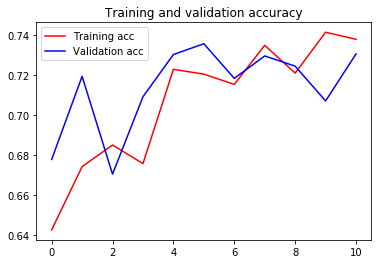

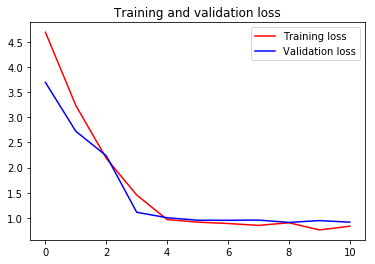

In [0]:
def plot_acc_loss(history,model_name):
  import matplotlib.pyplot as plt

  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.savefig(model_name+"acc.png")

  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.savefig(model_name+"loss.png")

  plt.show()

plot_acc_loss(history,"model_1")

As we notice from the previous plots, the maximum accuracy obtained on the validation set was around 74%, but we can do better. Next, we will try to fine-tune the model to try to increase its accuracy. 

## Improving the Model Accuracy by Adding Dropout and Batch Normalizaton

One approach to improve the accuracy and reduce overfitting is by adding a Dropout layer and a Batch Normalization layer to the dense layers: 

In [0]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(5, activation='softmax'))


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 16,814,405
Trainable params: 9,178,629
Non-trainable params: 7,635,776
_________________________________________________________

Next, we will freeze all the layers except the top layer:

In [0]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 12


In [0]:
conv_base.trainable = False

In [0]:
for layer in conv_base.layers:
  layer.trainable=False

In [0]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 6


Now we will train the model:

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
     horizontal_flip=True,
                                         vertical_flip=True, 
                                         rotation_range=40, 
                                         zoom_range=0.2, 
                                         shear_range=0.1,
                                        fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-4),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,class_weight=weights,callbacks=[early_stopper,reduce_lr])

Found 3112 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Epoch 1/50
100/100 [==============================] - 354s 4s/step - loss: 1.1300 - acc: 0.5945 - val_loss: 0.7446 - val_acc: 0.7414
Epoch 2/50
100/100 [==============================] - 326s 3s/step - loss: 0.8320 - acc: 0.6865 - val_loss: 0.8924 - val_acc: 0.7224
Epoch 3/50
100/100 [==============================] - 326s 3s/step - loss: 0.8637 - acc: 0.6825 - val_loss: 0.7787 - val_acc: 0.7224

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 4/50
100/100 [==============================] - 331s 3s/step - loss: 0.8028 - acc: 0.7007 - val_loss: 0.6850 - val_acc: 0.7357
Epoch 5/50
100/100 [==============================] - 323s 3s/step - loss: 0.7807 - acc: 0.7125 - val_loss: 0.6458 - val_acc: 0.7556
Epoch 6/50
100/100 [==============================] - 330s 3s/step - loss: 0.7430 - acc: 0.7200 - val_loss: 0.6520 - val_acc: 0.7469
Epoch 7/50
100/100 [=================

In [0]:
model.save("model_2.h5")

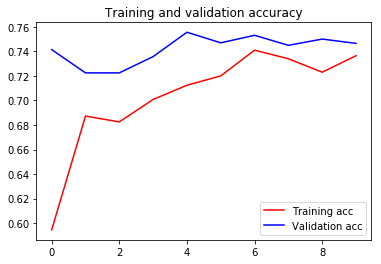

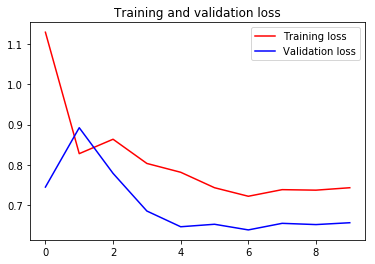

In [0]:
plot_acc_loss(history,"model_2")

As we notice from the previous plots, the maximum accuracy obtained on the validation set increased to reach around 75.56%, but we can do better. Next, we will try another approach to further improve the model.

In [0]:
NB_VALID_STEPS = validation_generator.n // validation_generator.batch_size
NB_VALID_STEPS

27

## Unfreezing the Last Layers

Another approach is to unfreeze the last layers and retrain the model again.
Let's repeat the process and unfreeze the last layer:

In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

We will unfreeze the block5_conv1 layer:

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,callbacks=[early_stopper,reduce_lr],class_weight=weights)

Epoch 1/100
100/100 [==============================] - 339s 3s/step - loss: 0.7258 - acc: 0.7288 - val_loss: 0.7136 - val_acc: 0.7357
Epoch 2/100
100/100 [==============================] - 319s 3s/step - loss: 0.7358 - acc: 0.7260 - val_loss: 0.6187 - val_acc: 0.7898
Epoch 3/100
100/100 [==============================] - 314s 3s/step - loss: 0.7059 - acc: 0.7443 - val_loss: 0.6561 - val_acc: 0.7663
Epoch 4/100
100/100 [==============================] - 315s 3s/step - loss: 0.6782 - acc: 0.7417 - val_loss: 0.6456 - val_acc: 0.7704

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 5/100
100/100 [==============================] - 314s 3s/step - loss: 0.6582 - acc: 0.7590 - val_loss: 0.6420 - val_acc: 0.7646
Epoch 6/100
100/100 [==============================] - 319s 3s/step - loss: 0.6904 - acc: 0.7492 - val_loss: 0.6336 - val_acc: 0.7653
Epoch 7/100
100/100 [==============================] - 319s 3s/step - loss: 0.6617 - acc: 0.7575 - val_loss: 0.6136 - val_acc: 0.77

In [0]:
model.save("model_3.h5")

Let's visualize the variation of the accuracy and loss in the training and validation set:

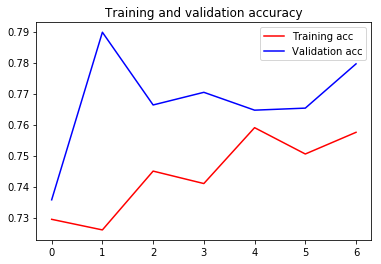

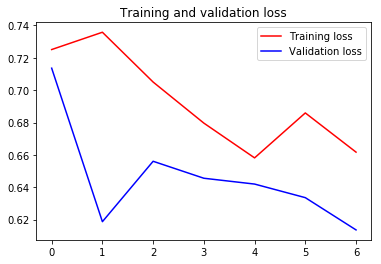

In [0]:
plot_acc_loss(history,"model_3")

Let's evaluate the accuracy of the model:

In [0]:
(eval_loss, eval_accuracy) = tqdm(
    model.evaluate_generator(generator=validation_generator, steps=NB_VALID_STEPS))
print("\nAccuracy: {:.2f}%".format(eval_accuracy * 100))
print("Loss: {}".format(eval_loss))

100%|██████████| 2/2 [00:00<00:00, 399.15it/s]


Accuracy: 77.92%
Loss: 0.6104685776638534


## Evaluating the Model Accuracy

Let's find the confusion matrix, which will help us pinpoint the weaknesses in our model:

In [0]:
train["id_code_png"]=train["id_code"]+".png"
train.head()

,id_code,diagnosis,id_code_png
0,000c1434d8d7,2,000c1434d8d7.png
1,001639a390f0,4,001639a390f0.png
2,0024cdab0c1e,1,0024cdab0c1e.png
3,002c21358ce6,0,002c21358ce6.png
4,005b95c28852,0,005b95c28852.png


In [0]:
val_test_names

['00524.png',
 '1295.png',
 '00745.png',
 '00240.png',
 '00392.png',
 '2522.png',
 '01047.png',
 '00243.png',
 '01548.png',
 '4138.png',
 '00123.png',
 '00177.png',
 '3077.png',
 '1356.png',
 '00159.png',
 '1257.png',
 '01504.png',
 '1045.png',
 '01293.png',
 '3034.png',
 '1304.png',
 '00843.png',
 '00886.png',
 '2753.png',
 '01536.png',
 '1035.png',
 '00224.png',
 '00797.png',
 '2135.png',
 '00227.png',
 '01494.png',
 '01295.png',
 '00900.png',
 '00744.png',
 '2694.png',
 '00431.png',
 '2519.png',
 '00927.png',
 '00300.png',
 '00270.png',
 '2873.png',
 '2976.png',
 '2991.png',
 '01734.png',
 '2887.png',
 '01591.png',
 '2862.png',
 '01128.png',
 '00899.png',
 '1354.png',
 '01183.png',
 '1340.png',
 '1313.png',
 '2379.png',
 '01184.png',
 '00928.png',
 '00006.png',
 '4051.png',
 '4175.png',
 '01174.png',
 '2185.png',
 '2600.png',
 '01607.png',
 '01249.png',
 '2370.png',
 '01255.png',
 '00232.png',
 '01465.png',
 '00786.png',
 '2488.png',
 '00707.png',
 '3014.png',
 '2812.png',
 '4210.pn

Let's get the predicted values for the validation set's images:

In [0]:
pred_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode='categorical',
shuffle=False)
valid_preds=model.predict_generator(generator=pred_generator,steps=len(val_test_names))
valid_preds

Found 550 images belonging to 5 classes.


array([[9.0531009e-01, 3.6436010e-02, 3.0811481e-02, 8.5924519e-03,
        1.8850021e-02],
       [9.4091189e-01, 2.4288848e-02, 2.3007609e-02, 4.3925503e-03,
        7.3991381e-03],
       [9.8184752e-01, 4.1682580e-03, 5.5666547e-03, 4.4757593e-03,
        3.9418531e-03],
       ...,
       [1.3321613e-01, 9.5946744e-02, 1.7630111e-01, 1.1120686e-01,
        4.8332912e-01],
       [1.1525477e-04, 1.6241843e-02, 3.4021795e-01, 2.7276927e-01,
        3.7065575e-01],
       [6.0772843e-04, 3.6462467e-02, 4.7979763e-01, 3.2541454e-01,
        1.5771766e-01]], dtype=float32)

In [0]:
preds=np.argmax(valid_preds,axis=1)
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 2, 2, 1, 1,

Next, let's sort the predicted labels:

In [0]:
sorted_val_test_names=sorted(val_test_names)
labels=np.zeros(len(val_test_names))
for i in range(len(val_test_names)):
  labels[i]=int(sorted_val_test_names[i][0])
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [0]:
vals,counts=np.unique(labels,return_counts=True)
print("Unique Values : " ,vals)
print("Occurrence Count : ", counts)

Unique Values :  [0. 1. 2. 3. 4.]
Occurrence Count :  [293  57 128  30  42]


Now, we are ready to find the confusion matrix:

In [0]:
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(labels,preds)
conf_mat

array([[287,   4,   2,   0,   0],
       [ 13,  16,  28,   0,   0],
       [ 13,   4, 108,   2,   1],
       [  3,   0,  19,   5,   3],
       [  4,   2,  24,   0,  12]])

Using the obtained matrix, let's compute the percentage of error for each class:

In [0]:
perc_mat=(conf_mat/counts[:,None])
perc_mat

array([[0.97952218, 0.01365188, 0.00682594, 0.        , 0.        ],
       [0.22807018, 0.28070175, 0.49122807, 0.        , 0.        ],
       [0.1015625 , 0.03125   , 0.84375   , 0.015625  , 0.0078125 ],
       [0.1       , 0.        , 0.63333333, 0.16666667, 0.1       ],
       [0.0952381 , 0.04761905, 0.57142857, 0.        , 0.28571429]])

Let's plot the percentages matrix:

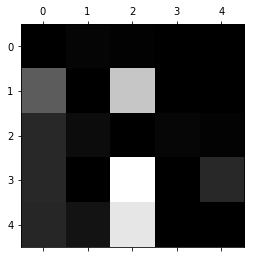

In [0]:
np.fill_diagonal(perc_mat, 0)
plt.matshow(perc_mat, cmap=plt.cm.gray)
plt.savefig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Let's calculate the f1 score for this model:

In [0]:
from sklearn.metrics import f1_score
f1=f1_score(labels,preds,average="weighted")
f1

0.7478144380440027

## Trying ResNet model
To try to improve the accuracy of the model, let's try another model - Resnet50. 
Using this model, let's repeat the process we used in the previous model: 

In [0]:
from keras.applications import ResNet50

res_base=ResNet50(include_top = False, pooling = "avg", weights = "imagenet",input_shape=(224,224,3))

W0816 21:13:39.585263 140702912399232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



94658560/94653016 [==============================] - 8s 0us/step


In [0]:
res_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
res_model = models.Sequential()
res_model.add(res_base)
res_model.add(layers.Dropout(0.3))
res_model.add(layers.Dense(1024, activation='relu'))
res_model.add(layers.Dropout(0.2))
res_model.add(layers.Dense(512, activation='relu'))
res_model.add(layers.Dropout(0.2))
res_model.add(layers.BatchNormalization())
res_model.add(layers.Dense(5, activation='softmax'))


In [0]:
res_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
__________

In [0]:
print('This is the number of trainable weights '
      'before freezing the res base:', len(res_model.trainable_weights))

This is the number of trainable weights before freezing the res base: 220


In [0]:
for layer in res_base.layers:
  layer.trainable=False

In [0]:
res_base.trainable = False

In [0]:
print('This is the number of trainable weights '
      'after freezing the res base:', len(res_model.trainable_weights))

This is the number of trainable weights after freezing the res base: 8


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
     horizontal_flip=True,
     vertical_flip=True, 
     rotation_range=360, 
     zoom_range=0.2, 
     shear_range=0.1,
    fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=12,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=12,
        class_mode='categorical')

res_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.sgd(lr=1e-3),
              metrics=['acc'])

res_history = res_model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,class_weight=weights,callbacks=[early_stopper,reduce_lr])

Found 3112 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Epoch 1/50
100/100 [==============================] - 194s 2s/step - loss: 1.8842 - acc: 0.2917 - val_loss: 1.3950 - val_acc: 0.3813
Epoch 2/50
100/100 [==============================] - 179s 2s/step - loss: 1.5251 - acc: 0.4175 - val_loss: 1.2801 - val_acc: 0.5418
Epoch 3/50
100/100 [==============================] - 175s 2s/step - loss: 1.3291 - acc: 0.5158 - val_loss: 1.2080 - val_acc: 0.5803
Epoch 4/50
100/100 [==============================] - 174s 2s/step - loss: 1.1974 - acc: 0.5758 - val_loss: 1.1416 - val_acc: 0.5903
Epoch 5/50
100/100 [==============================] - 181s 2s/step - loss: 1.2149 - acc: 0.5617 - val_loss: 1.2397 - val_acc: 0.5886
Epoch 6/50
100/100 [==============================] - 170s 2s/step - loss: 1.0470 - acc: 0.6400 - val_loss: 1.2632 - val_acc: 0.5552

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/50
100/100 [=================

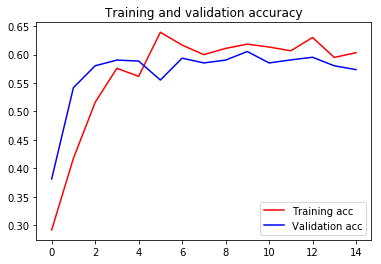

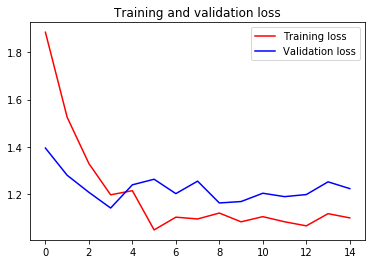

In [0]:
plot_acc_loss(res_history,"res_model")

We notice that the accuracy of the model did not improve at all using this model, instead it decreased. It seems that ResNet50 is not very fit for this kind of pictures. 

## Another Approach: Model Training Based on Extracted Features
The last approach we will be tackling is using a pretrained model with the latest layer removed, to extract the features of the pictures, which we will later on feed into a machine learning model that will try to predict the severity of the disease. <br>
We will be using MobileNetV2 model, one of the models with the highest accuracy:

In [0]:
from keras.applications import MobileNetV2
inc_base=MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))

W0818 06:58:27.194669 139690505389952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 06:58:27.244970 139690505389952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 06:58:27.262340 139690505389952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0818 06:58:27.305329 139690505389952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0818 06:58:27.306528 1396905053

9412608/9406464 [==============================] - 0s 0us/step


Let's extract the features from the training and validation sets:

In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7,7,1280))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = inc_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = np.argmax(labels_batch,axis=1)
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_samples = 3112
#test_samples = 
validation_samples = 550

train_features, train_labels = extract_features(train_dir, train_samples)
validation_features, validation_labels = extract_features(validation_dir, validation_samples)
#test_features, test_labels = extract_features(test_dir, test_samples)

Found 3112 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


In [0]:
train_features = np.reshape(train_features, (train_samples, 7 * 7 * 1280))
validation_features = np.reshape(validation_features, (validation_samples, 7 * 7 * 1280))
#test_features = np.reshape(test_features, (test_samples, 7 * 7 * 1280))

In [0]:
from keras.utils import to_categorical
train_labels_cat = to_categorical(train_labels)
validation_labels_cat=to_categorical(validation_labels)

### Training a Neural Network Using Extracted Features
Now we have the extracted features from the train and validation sets ready, we will first train a neural netwrork on the training set features:

In [0]:
inc_model = models.Sequential()
inc_model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 1280))
inc_model.add(layers.Dropout(0.5))
inc_model.add(layers.BatchNormalization())
inc_model.add(layers.Dense(5, activation='softmax'))

inc_model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = inc_model.fit(train_features, train_labels_cat,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels_cat))

Train on 3112 samples, validate on 550 samples
Epoch 1/30
3112/3112 [==============================] - 11s 4ms/step - loss: 1.0021 - acc: 0.6472 - val_loss: 0.7635 - val_acc: 0.7582
Epoch 2/30
3112/3112 [==============================] - 5s 1ms/step - loss: 0.7405 - acc: 0.7503 - val_loss: 0.6281 - val_acc: 0.7764
Epoch 3/30
3112/3112 [==============================] - 4s 1ms/step - loss: 0.6119 - acc: 0.7863 - val_loss: 0.6407 - val_acc: 0.7764
Epoch 4/30
3112/3112 [==============================] - 4s 1ms/step - loss: 0.5396 - acc: 0.8078 - val_loss: 0.6353 - val_acc: 0.7691
Epoch 5/30
3112/3112 [==============================] - 4s 1ms/step - loss: 0.4588 - acc: 0.8470 - val_loss: 0.6247 - val_acc: 0.7891
Epoch 6/30
3112/3112 [==============================] - 5s 1ms/step - loss: 0.4029 - acc: 0.8602 - val_loss: 0.6457 - val_acc: 0.7855
Epoch 7/30
3112/3112 [==============================] - 4s 1ms/step - loss: 0.3599 - acc: 0.8837 - val_loss: 0.5910 - val_acc: 0.7964
Epoch 8/30
311

Let's plot the accuracy and error for the training and validation sets:

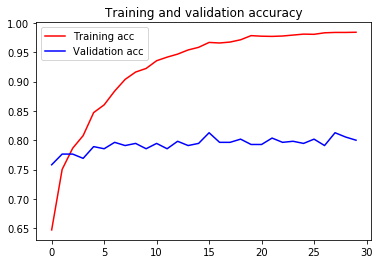

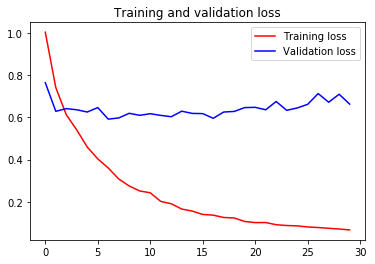

In [0]:
plot_acc_loss(history,"inc_model")

In [0]:
(eval_loss, eval_accuracy) = tqdm(
    inc_model.evaluate(validation_features, validation_labels_cat))
print("\nAccuracy: {:.2f}%".format(eval_accuracy * 100))
print("Loss: {}".format(eval_loss))

550/550 [==============================] - 0s 496us/step


100%|██████████| 2/2 [00:00<00:00, 896.22it/s]


Accuracy: 80.00%
Loss: 0.6620255652340976


Now we notice that the accuracy of the model has increased to 80%!!
Let's check if we can further improve it using another learning model for the extracted features:

### Training a Support Vector Machines Classifier
Instead of a neural network, let's try a support vector machines (SVMs) classifier:

In [0]:
from sklearn.svm import SVC
ml_model=SVC(random_state=SEED,verbose=True,kernel="linear",C=1,class_weight="balanced")

In [0]:
ml_model.fit(train_features, train_labels)

[LibSVM]

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=True)

In [0]:
pred_train_labels=ml_model.predict(train_features)

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(train_labels, pred_train_labels)

0.9922879177377892

In [0]:
pred_valid_labels=ml_model.predict(validation_features)
accuracy_score(validation_labels, pred_valid_labels)

0.8145454545454546

The model accuracy has increased to 81.45%, let's find the cohen kappa score, another performance measure and generate a classification report: 

In [0]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(train_labels, pred_train_labels)

0.9884379856013539

In [0]:
cohen_kappa_score(validation_labels, pred_valid_labels)

0.7086546700942588

In [0]:
from sklearn.metrics import classification_report
print(classification_report(train_labels, pred_train_labels))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1527
         1.0       0.98      1.00      0.99       316
         2.0       1.00      0.98      0.99       845
         3.0       0.93      1.00      0.97       172
         4.0       0.97      0.99      0.98       252

    accuracy                           0.99      3112
   macro avg       0.98      0.99      0.99      3112
weighted avg       0.99      0.99      0.99      3112



In [0]:
print(classification_report(validation_labels, pred_valid_labels))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       278
         1.0       0.57      0.50      0.53        54
         2.0       0.70      0.81      0.75       154
         3.0       0.41      0.33      0.37        21
         4.0       0.62      0.37      0.46        43

    accuracy                           0.81       550
   macro avg       0.65      0.60      0.62       550
weighted avg       0.81      0.81      0.81       550



## Tuning the Hyperparameters
Let's apply a randomized search to find the best hyperparameter values:

In [0]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'C':[1,10,100],'gamma':[1,0.1,0.001,0.0001]}

grid_search = RandomizedSearchCV(SVC(kernel="linear",class_weight="balanced"), param_grid, cv=3, verbose=5, n_jobs=-1)
grid_search.fit(train_features, train_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 32.8min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 83.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 83.5min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='linear', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [1, 10, 100],
                                        'gamma': [1, 0.1, 0.001, 0.0001]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=5)

In [0]:
grid_search.best_params_

{'C': 10, 'gamma': 1}

In [0]:
grid_search.best_score_

0.7737789203084833

In [0]:
pred_valid_labels=grid_search.predict(validation_features)
accuracy_score(validation_labels, pred_valid_labels)

0.8145454545454546

In [0]:
print(classification_report(validation_labels, pred_valid_labels))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       278
         1.0       0.57      0.50      0.53        54
         2.0       0.70      0.81      0.75       154
         3.0       0.41      0.33      0.37        21
         4.0       0.62      0.37      0.46        43

    accuracy                           0.81       550
   macro avg       0.65      0.60      0.62       550
weighted avg       0.81      0.81      0.81       550



It seems that the accuracy of the model has not changed!  <br>
We will stop at this stage, but there is a lot of room for improvement. Further steps to improve the model might be:
- preprocessing the images to better expose the most important features 
- trying other pretrained models
